In [3]:
from os import listdir
from os.path import isdir, join
import librosa
import random
import numpy as np
import matplotlib.pyplot as plt
import python_speech_features

In [5]:
# Dataset path and view possible targets
dataset_path = 'C:\\Users\Greg\ML\Technical\project\sample\data\Winds'
for name in listdir(dataset_path):
    if isdir(join(dataset_path, name)):
        print(name)

Bassoon
Clarinet_Bb
Flute
Oboe
Sax_Alto


In [6]:
# Create an all targets list
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
print(all_targets)

['Bassoon', 'Clarinet_Bb', 'Flute', 'Oboe', 'Sax_Alto']


In [7]:
# Leave off background noise set
all_targets.remove('_background_noise_')
print(all_targets)

ValueError: list.remove(x): x not in list

In [8]:
# See how many files are in each
num_samples = 0
for target in all_targets:
    print(len(listdir(join(dataset_path, target))))
    num_samples += len(listdir(join(dataset_path, target)))
print('Total samples:', num_samples)

126
126
118
107
99
Total samples: 576


In [9]:
# Settings
target_list = all_targets
feature_sets_file = 'all_targets_mfcc_sets.npz'
perc_keep_samples = 1.0 # 1.0 is keep all samples
val_ratio = 0.1
test_ratio = 0.1
sample_rate = 8000
num_mfcc = 16
len_mfcc = 16

In [10]:
# Create list of filenames along with ground truth vector (y)
filenames = []
y = []
for index, target in enumerate(target_list):
    print(join(dataset_path, target))
    filenames.append(listdir(join(dataset_path, target)))
    y.append(np.ones(len(filenames[index])) * index)

C:\Users\Greg\ML\Technical\project\sample\data\Winds\Bassoon
C:\Users\Greg\ML\Technical\project\sample\data\Winds\Clarinet_Bb
C:\Users\Greg\ML\Technical\project\sample\data\Winds\Flute
C:\Users\Greg\ML\Technical\project\sample\data\Winds\Oboe
C:\Users\Greg\ML\Technical\project\sample\data\Winds\Sax_Alto


In [11]:
# Check ground truth Y vector
print(y)
for item in y:
    print(len(item))

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,

In [12]:
# Flatten filename and y vectors
filenames = [item for sublist in filenames for item in sublist]
y = [item for sublist in y for item in sublist]

In [13]:
# Associate filenames with true output and shuffle
filenames_y = list(zip(filenames, y))
random.shuffle(filenames_y)
filenames, y = zip(*filenames_y)

In [14]:
# Only keep the specified number of samples (shorter extraction/training)
print(len(filenames))
filenames = filenames[:int(len(filenames) * perc_keep_samples)]
print(len(filenames))

576
576


In [15]:
# Calculate validation and test set sizes
val_set_size = int(len(filenames) * val_ratio)
test_set_size = int(len(filenames) * test_ratio)

In [16]:
# Break dataset apart into train, validation, and test sets
filenames_val = filenames[:val_set_size]
filenames_test = filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = filenames[(val_set_size + test_set_size):]

In [17]:
# Break y apart into train, validation, and test sets
y_orig_val = y[:val_set_size]
y_orig_test = y[val_set_size:(val_set_size + test_set_size)]
y_orig_train = y[(val_set_size + test_set_size):]

In [18]:
# Function: Create MFCC from given path
def calc_mfcc(path):
    
    # Load wavefile
    signal, fs = librosa.load(path, sr=sample_rate)
    
    # Create MFCCs from sound clip
    mfccs = python_speech_features.base.mfcc(signal, 
                                            samplerate=fs,
                                            winlen=0.256,
                                            winstep=0.050,
                                            numcep=num_mfcc,
                                            nfilt=26,
                                            nfft=2048,
                                            preemph=0.0,
                                            ceplifter=0,
                                            appendEnergy=False,
                                            winfunc=np.hanning)
    return mfccs.transpose()

In [19]:
# TEST: Construct test set by computing MFCC of each WAV file
prob_cnt = 0
x_test = []
y_test = []
for index, filename in enumerate(filenames_train):
    
    # Stop after 500
    if index >= 500:
        break
    
    # Create path from given filename and target item
    path = join(dataset_path, target_list[int(y_orig_train[index])], 
                filename)
    
    # Create MFCCs
    mfccs = calc_mfcc(path)
    
    if mfccs.shape[1] == len_mfcc:
        x_test.append(mfccs)
        y_test.append(y_orig_train[index])
    else:
        print('Dropped:', index, mfccs.shape)
        prob_cnt += 1
        

Dropped: 0 (16, 118)
Dropped: 1 (16, 124)
Dropped: 2 (16, 141)
Dropped: 3 (16, 134)
Dropped: 4 (16, 123)
Dropped: 5 (16, 131)
Dropped: 6 (16, 150)
Dropped: 7 (16, 150)
Dropped: 8 (16, 119)
Dropped: 9 (16, 128)
Dropped: 10 (16, 124)
Dropped: 11 (16, 113)
Dropped: 12 (16, 133)
Dropped: 13 (16, 129)
Dropped: 14 (16, 107)
Dropped: 15 (16, 135)
Dropped: 16 (16, 130)
Dropped: 17 (16, 138)
Dropped: 18 (16, 130)
Dropped: 19 (16, 67)
Dropped: 20 (16, 157)
Dropped: 21 (16, 129)
Dropped: 22 (16, 160)
Dropped: 23 (16, 118)
Dropped: 24 (16, 147)
Dropped: 25 (16, 134)
Dropped: 26 (16, 122)
Dropped: 27 (16, 119)
Dropped: 28 (16, 132)
Dropped: 29 (16, 133)
Dropped: 30 (16, 124)
Dropped: 31 (16, 128)
Dropped: 32 (16, 134)
Dropped: 33 (16, 124)
Dropped: 34 (16, 123)
Dropped: 35 (16, 136)
Dropped: 36 (16, 112)
Dropped: 37 (16, 140)
Dropped: 38 (16, 136)
Dropped: 39 (16, 98)
Dropped: 40 (16, 131)
Dropped: 41 (16, 121)
Dropped: 42 (16, 126)
Dropped: 43 (16, 120)
Dropped: 44 (16, 136)
Dropped: 45 (16, 112)


In [20]:
print('% of problematic samples:', prob_cnt / 500)

% of problematic samples: 0.924


MFCCs: [[-68.99680972 -69.83887715 -70.03926627 ... -92.71528845 -95.36502539
  -97.96689349]
 [ -9.13756384  -8.67125545  -8.48250931 ...  -1.39373036  -1.09983297
   -1.41208418]
 [-10.02758803  -9.86671219 -10.19885255 ...  -4.5418733   -3.62974145
   -3.27450827]
 ...
 [ -2.18422423  -2.23051681  -2.19432682 ...  -1.18098783  -1.11635011
   -0.84785165]
 [  6.34415265   6.42866707   6.33445466 ...   4.19055185   4.28850803
    4.56656395]
 [ -1.66878007  -1.47260835  -1.14109532 ...  -2.04515187  -2.0030131
   -1.87449886]]
Flute


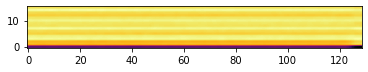

In [21]:
# TEST: Test shorter MFCC
# !pip install playsound
from playsound import playsound

idx = 13

# Create path from given filename and target item
path = join(dataset_path, target_list[int(y_orig_train[idx])], 
            filenames_train[idx])

# Create MFCCs
mfccs = calc_mfcc(path)
print("MFCCs:", mfccs)

# Plot MFCC
fig = plt.figure()
plt.imshow(mfccs, cmap='inferno', origin='lower')

# TEST: Play problem sounds
print(target_list[int(y_orig_train[idx])])
playsound(path)

In [22]:
# Function: Create MFCCs, keeping only ones of desired length
def extract_features(in_files, in_y):
    prob_cnt = 0
    out_x = []
    out_y = []
        
    for index, filename in enumerate(in_files):
    
        # Create path from given filename and target item
        path = join(dataset_path, target_list[int(in_y[index])], 
                    filename)
        
        # Check to make sure we're reading a .wav file
        if not path.endswith('.wav'):
            continue

        # Create MFCCs
        mfccs = calc_mfcc(path)

        # Only keep MFCCs with given length
        if mfccs.shape[1] == len_mfcc:
            out_x.append(mfccs)
            out_y.append(in_y[index])
        else:
            print('Dropped:', index, mfccs.shape)
            prob_cnt += 1
            
    return out_x, out_y, prob_cnt

In [23]:
# Create train, validation, and test sets
x_train, y_train, prob = extract_features(filenames_train, 
                                          y_orig_train)
print('Removed percentage:', prob / len(y_orig_train))
x_val, y_val, prob = extract_features(filenames_val, y_orig_val)
print('Removed percentage:', prob / len(y_orig_val))
x_test, y_test, prob = extract_features(filenames_test, y_orig_test)
print('Removed percentage:', prob / len(y_orig_test))

Dropped: 0 (16, 118)
Dropped: 1 (16, 124)
Dropped: 2 (16, 141)
Dropped: 3 (16, 134)
Dropped: 4 (16, 123)
Dropped: 5 (16, 131)
Dropped: 6 (16, 150)
Dropped: 7 (16, 150)
Dropped: 8 (16, 119)
Dropped: 9 (16, 128)
Dropped: 10 (16, 124)
Dropped: 11 (16, 113)
Dropped: 12 (16, 133)
Dropped: 13 (16, 129)
Dropped: 14 (16, 107)
Dropped: 15 (16, 135)
Dropped: 16 (16, 130)
Dropped: 17 (16, 138)
Dropped: 18 (16, 130)
Dropped: 19 (16, 67)
Dropped: 20 (16, 157)
Dropped: 21 (16, 129)
Dropped: 22 (16, 160)
Dropped: 23 (16, 118)
Dropped: 24 (16, 147)
Dropped: 25 (16, 134)
Dropped: 26 (16, 122)
Dropped: 27 (16, 119)
Dropped: 28 (16, 132)
Dropped: 29 (16, 133)
Dropped: 30 (16, 124)
Dropped: 31 (16, 128)
Dropped: 32 (16, 134)
Dropped: 33 (16, 124)
Dropped: 34 (16, 123)
Dropped: 35 (16, 136)
Dropped: 36 (16, 112)
Dropped: 37 (16, 140)
Dropped: 38 (16, 136)
Dropped: 39 (16, 98)
Dropped: 40 (16, 131)
Dropped: 41 (16, 121)
Dropped: 42 (16, 126)
Dropped: 43 (16, 120)
Dropped: 44 (16, 136)
Dropped: 45 (16, 112)


In [24]:
# Save features and truth vector (y) sets to disk
np.savez(feature_sets_file, 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val, 
         x_test=x_test, 
         y_test=y_test)

In [25]:
# TEST: Load features
feature_sets = np.load(feature_sets_file)
feature_sets.files

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']

In [26]:
len(feature_sets['x_train'])

0

In [27]:
print(feature_sets['y_val'])

[]
